选择数据集

shape of moons:  (10000, 3)
shape of moons:  (10000, 2)


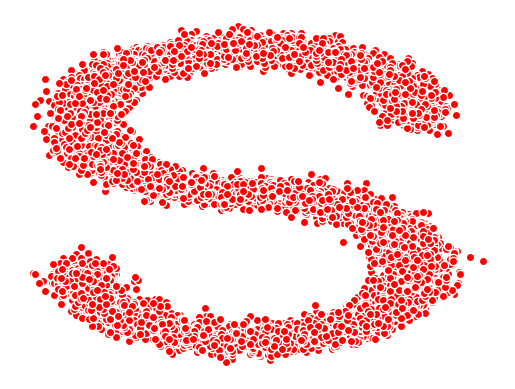

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch

s_curve, _ = make_s_curve(10**4, noise=0.1)
print("shape of moons: ", np.shape(s_curve))

s_curve = s_curve[:, [0, 2]] / 10.0
print("shape of moons: ", np.shape(s_curve))

data = s_curve.T
fig, ax = plt.subplots()
ax.scatter(*data, color='red', edgecolor='white')
ax.axis('off')

dataset = torch.Tensor(s_curve).float()

确定超参数的值

alphas -> $\alpha$

alphas_prod -> $\alpha_t$

alphas_prod_p -> $\alpha_{t-1}$

alphas_bar_sqrt -> $\sqrt{\bar{\alpha}_t}$

one_minus_alphas_bar_log -> $\log(1 - \bar{\alpha}_t)$

one_minus_alphas_bar_sqrt -> $\sqrt{1 - \bar{\alpha}_t}$

In [2]:
# 对于步骤，一开始可以由 β 、分布的均值和标准差共同决定
num_steps = 100

# 制定每一步的beta
betas = torch.linspace(-6, 6, num_steps)
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5

# 计算 α 、alpha_prod、alpha_previous、alpha_bar_sqrt等变量的值
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape == alphas_prod.shape \
    == alphas_prod_p.shape == alphas_bar_sqrt.shape \
    == one_minus_alphas_bar_log.shape == one_minus_alphas_bar_sqrt.shape 

print("all the same shape: ", alphas.shape)

all the same shape:  torch.Size([100])


确定扩散过程任意时刻的采样值
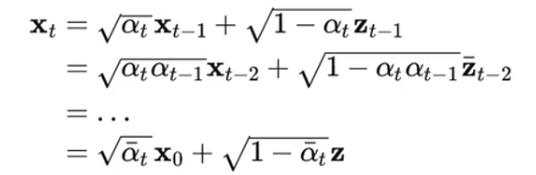

In [3]:
# 计算任意时刻的 x 的采样值，基于 x_0 和参数重整化技巧
# 可以基于 x[0] 得到任意时刻的 x[t]
def q_x(x_0, t):
    noise = torch.randn_like(x_0)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]

    return (alphas_t * x_0 + alphas_1_m_t * noise)

演示原始数据分布加噪之后100步的效果

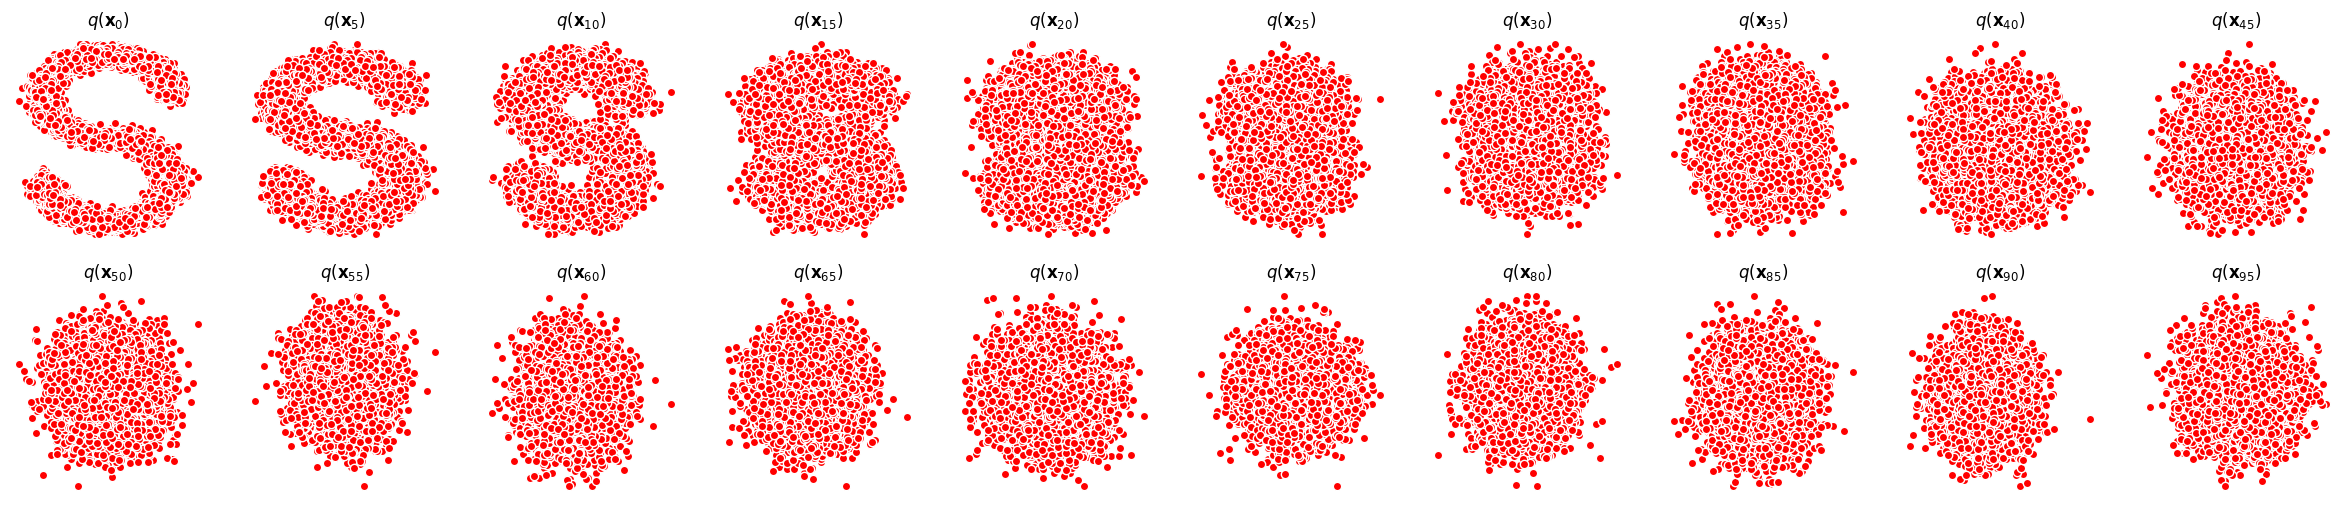

In [4]:
num_shows = 20
fig, axs = plt.subplots(2, 10, figsize=(30, 6))
plt.rc('text', color='green')

for i in range(num_shows):
    j = i // 10
    k = i % 10
    # 生成 t 时刻的采样数据
    q_i = q_x(dataset, torch.tensor([i * num_steps // num_shows]))

    axs[j, k].scatter(q_i[:, 0], q_i[:, 1], color='red', edgecolor='white')
    axs[j, k].set_axis_off()
    axs[j, k].set_title('$q(\mathbf{x}_{'+ str(i * num_steps // num_shows) +'})$')


编写拟合扩散过程高斯混合分布的模型

In [5]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    def __init__(self, n_steps, num_units=128):
        super(MLPDiffusion,self).__init__()
        
        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2),
            ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
            ]
        )
    def forward(self, x_0, t):
        x = x_0
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2 * idx](x)
            x += t_embedding
            x = self.linears[2 * idx + 1](x)
            
        x = self.linears[-1](x)
        
        return x

编写训练的误差损失函数



In [6]:
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    batch_size = x_0.shape[0]

    # 对一个batchsize样本生成随机的时刻t
    t = torch.randint(0, n_steps, size=(batch_size // 2, ))
    t = torch.cat([t,n_steps-1-t], dim=0)
    t = t.unsqueeze(-1)
    
    # x0的系数
    a = alphas_bar_sqrt[t]
    
    # eps的系数
    aml = one_minus_alphas_bar_sqrt[t]
    
    # 生成随机噪音eps
    e = torch.randn_like(x_0)
    
    # 构造模型的输入
    x = x_0 * a + e * aml
    
    # 送入模型，得到t时刻的随机噪声预测值
    output = model(x, t.squeeze(-1))
    
    # 与真实噪声一起计算误差，求平均值
    return (e - output).square().mean()

编写逆扩散采样函数

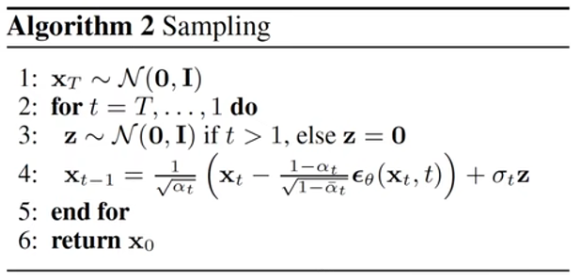

In [7]:
def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    """从x[T]恢复x[T-1]、x[T-2]|...x[0]"""
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    """从x[T]采样t时刻的重构值"""
    t = torch.tensor([t])
    
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    
    eps_theta = model(x, t)
    
    mean = (1/(1-betas[t]).sqrt())*(x-(coeff*eps_theta))
    
    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    
    sample = mean + sigma_t * z
    
    return (sample)

Training model...
tensor(0.4411, grad_fn=<MeanBackward0>)
tensor(0.3062, grad_fn=<MeanBackward0>)
tensor(0.4375, grad_fn=<MeanBackward0>)
tensor(0.3440, grad_fn=<MeanBackward0>)
tensor(0.4332, grad_fn=<MeanBackward0>)
tensor(0.4944, grad_fn=<MeanBackward0>)
tensor(0.4890, grad_fn=<MeanBackward0>)
tensor(0.4229, grad_fn=<MeanBackward0>)
tensor(0.7972, grad_fn=<MeanBackward0>)
tensor(0.3383, grad_fn=<MeanBackward0>)
tensor(0.2487, grad_fn=<MeanBackward0>)
tensor(0.3775, grad_fn=<MeanBackward0>)
tensor(0.2041, grad_fn=<MeanBackward0>)
tensor(0.1707, grad_fn=<MeanBackward0>)
tensor(0.3399, grad_fn=<MeanBackward0>)
tensor(0.1688, grad_fn=<MeanBackward0>)
tensor(0.3369, grad_fn=<MeanBackward0>)
tensor(0.2095, grad_fn=<MeanBackward0>)
tensor(0.2531, grad_fn=<MeanBackward0>)
tensor(0.5573, grad_fn=<MeanBackward0>)
tensor(0.5781, grad_fn=<MeanBackward0>)


C:\Users\17914\AppData\Local\Temp\ipykernel_21308\1088065572.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(1,10,figsize=(28,3))


tensor(0.3321, grad_fn=<MeanBackward0>)
tensor(0.3665, grad_fn=<MeanBackward0>)
tensor(0.3089, grad_fn=<MeanBackward0>)
tensor(0.4998, grad_fn=<MeanBackward0>)
tensor(0.3770, grad_fn=<MeanBackward0>)
tensor(0.2837, grad_fn=<MeanBackward0>)
tensor(0.2297, grad_fn=<MeanBackward0>)
tensor(0.2699, grad_fn=<MeanBackward0>)
tensor(0.4620, grad_fn=<MeanBackward0>)
tensor(0.4410, grad_fn=<MeanBackward0>)
tensor(0.3277, grad_fn=<MeanBackward0>)
tensor(0.2406, grad_fn=<MeanBackward0>)
tensor(0.6411, grad_fn=<MeanBackward0>)
tensor(0.3039, grad_fn=<MeanBackward0>)
tensor(0.1360, grad_fn=<MeanBackward0>)
tensor(0.3466, grad_fn=<MeanBackward0>)
tensor(0.1726, grad_fn=<MeanBackward0>)
tensor(0.4243, grad_fn=<MeanBackward0>)
tensor(0.4888, grad_fn=<MeanBackward0>)


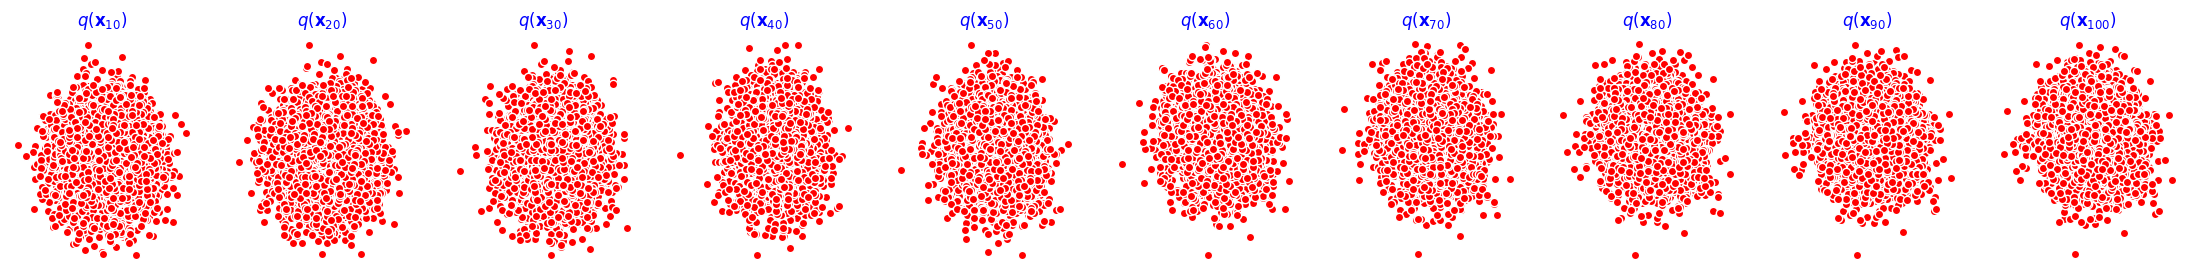

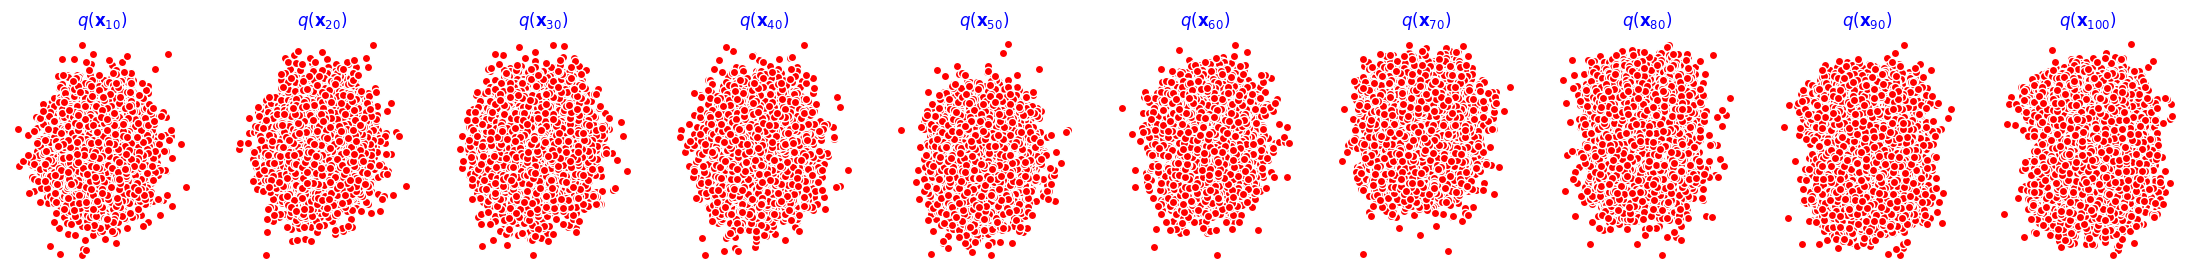

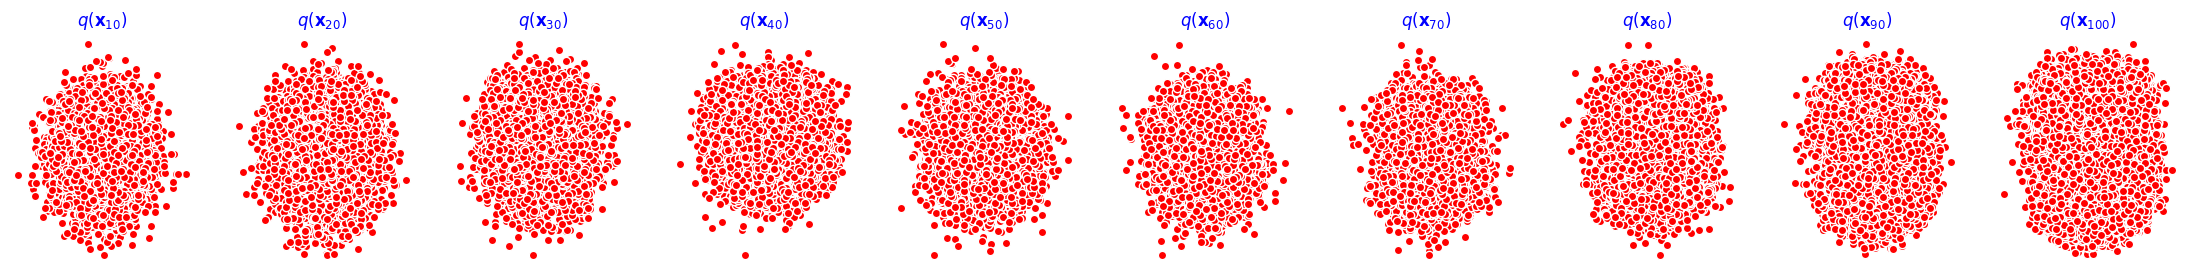

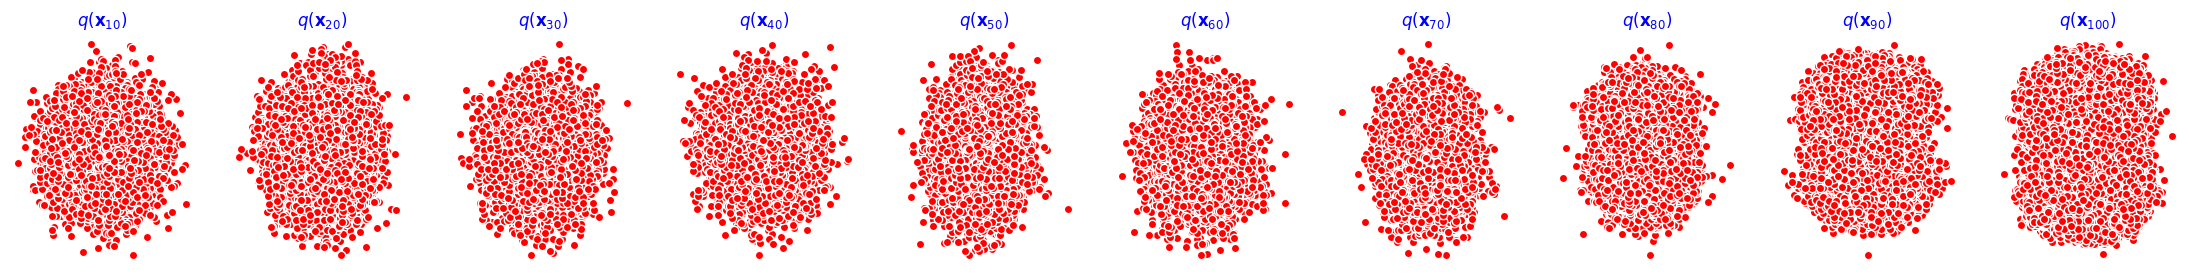

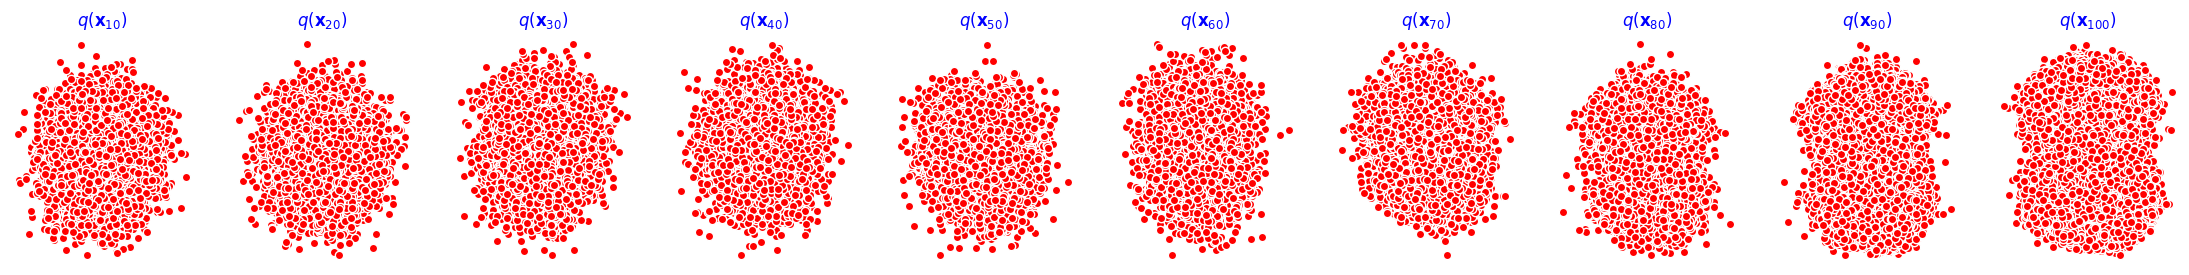

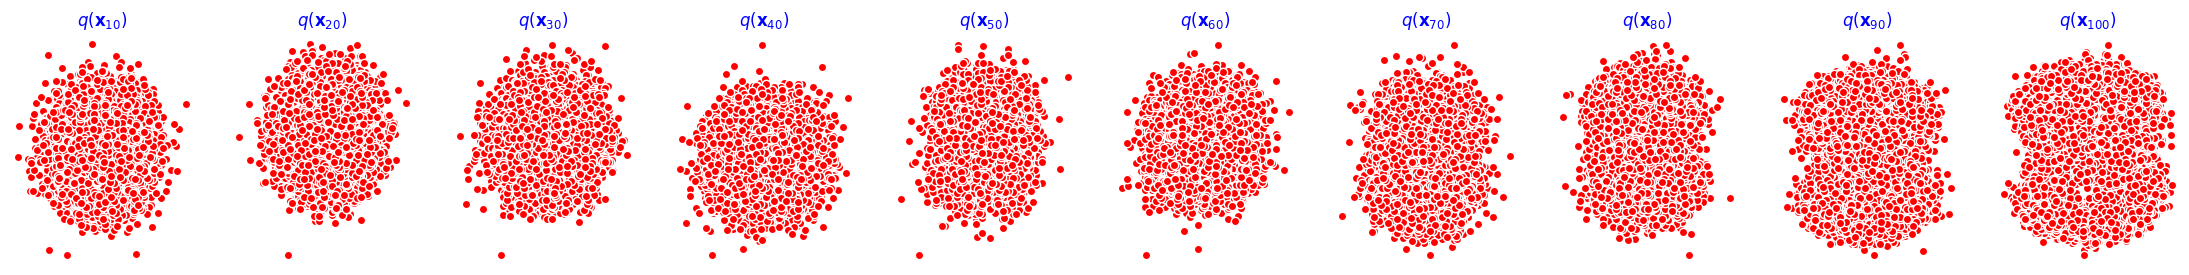

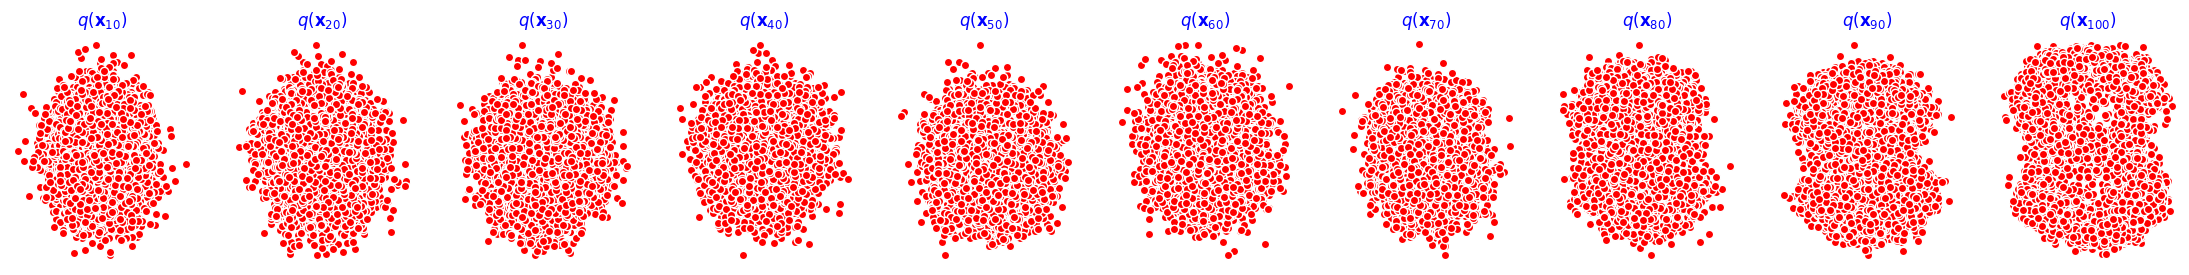

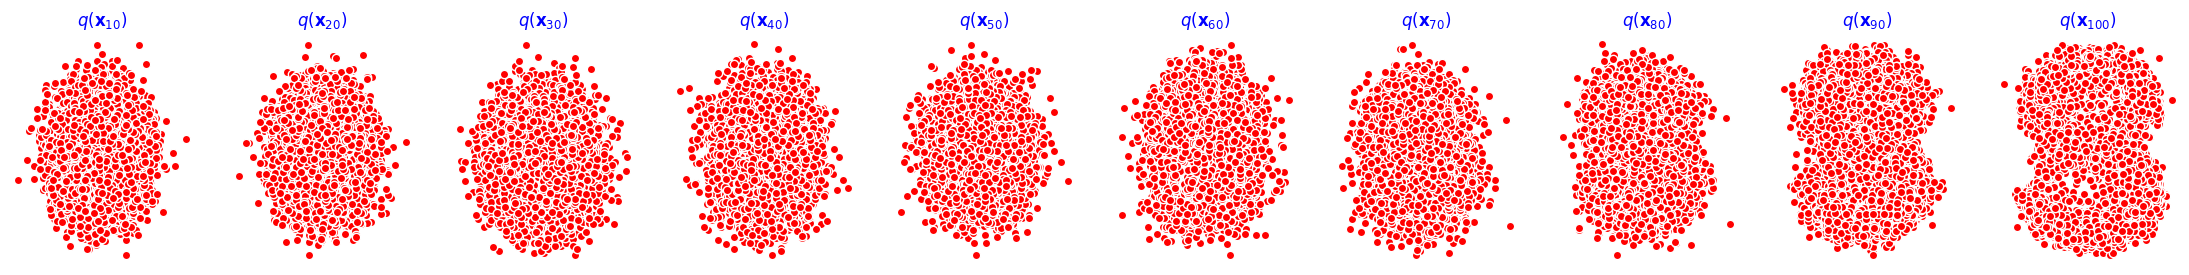

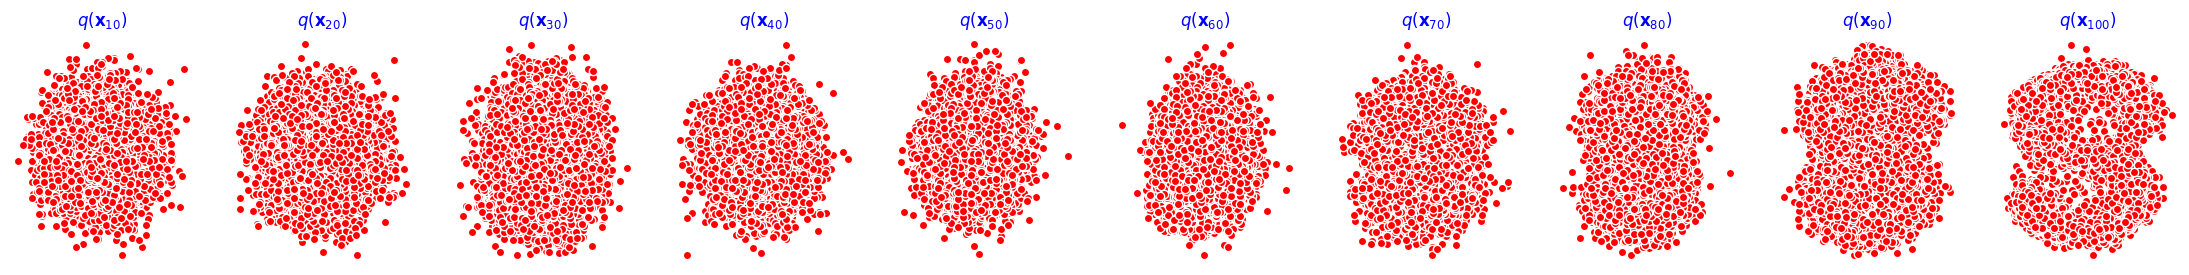

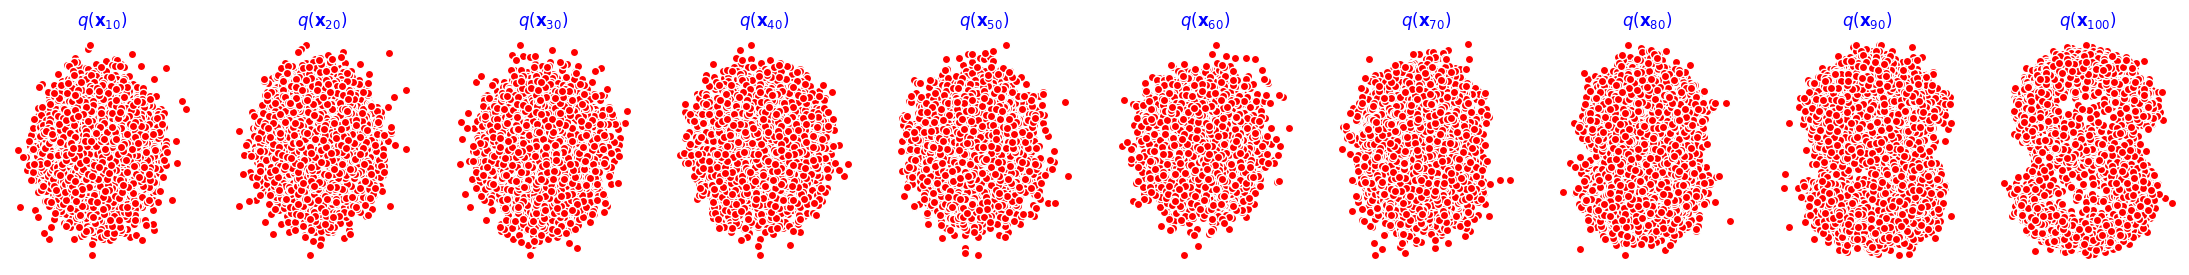

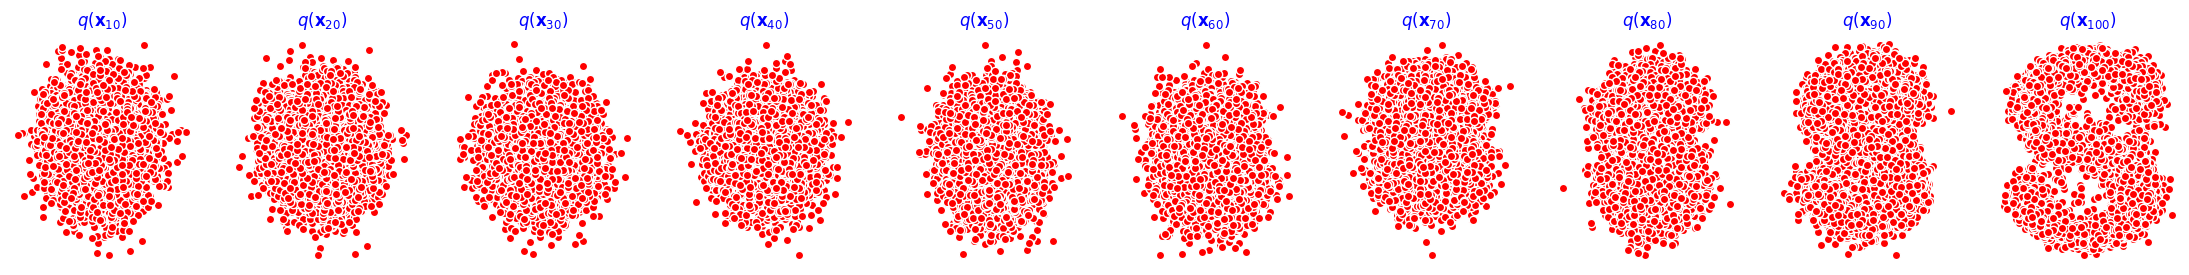

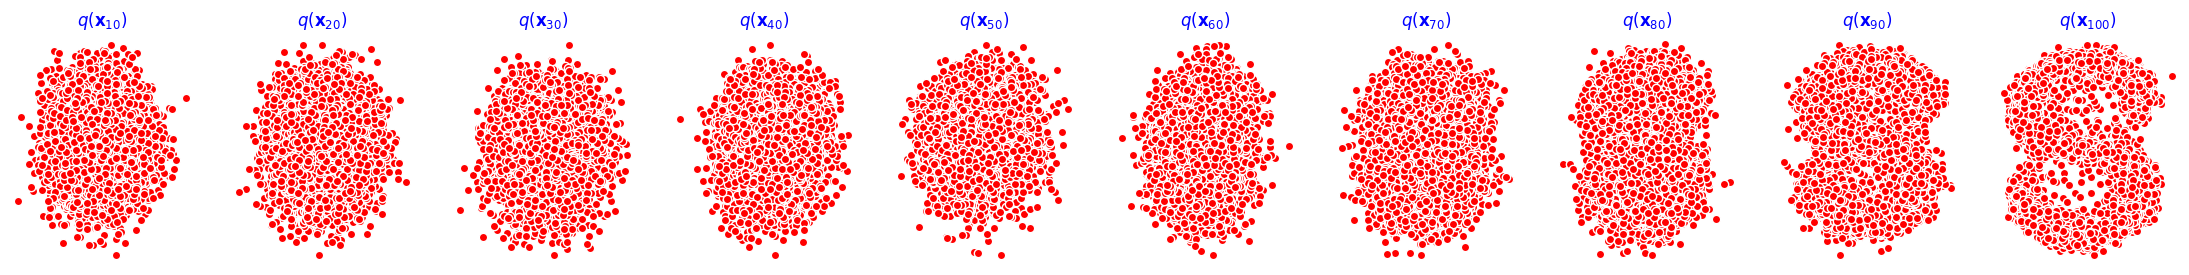

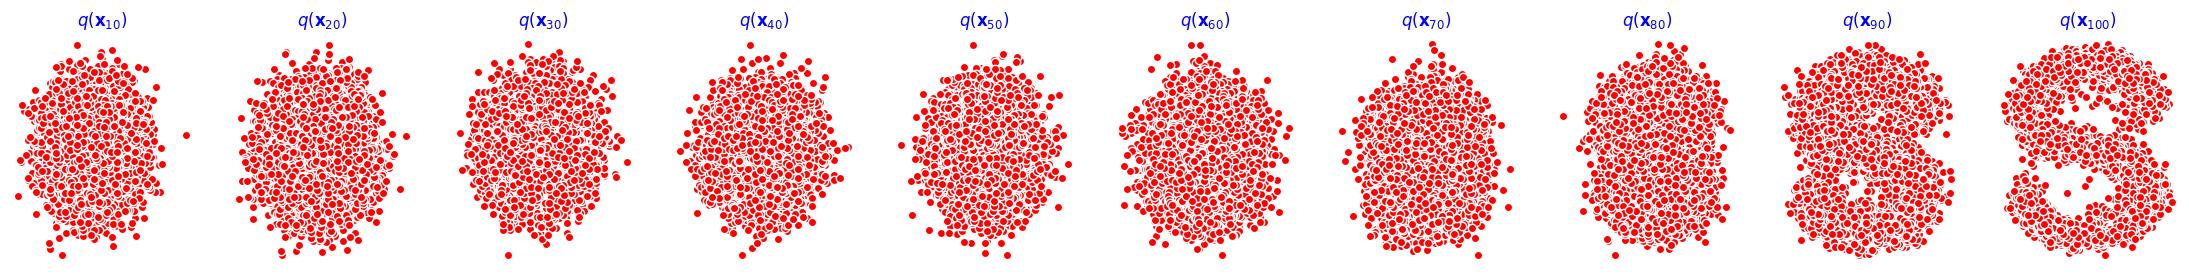

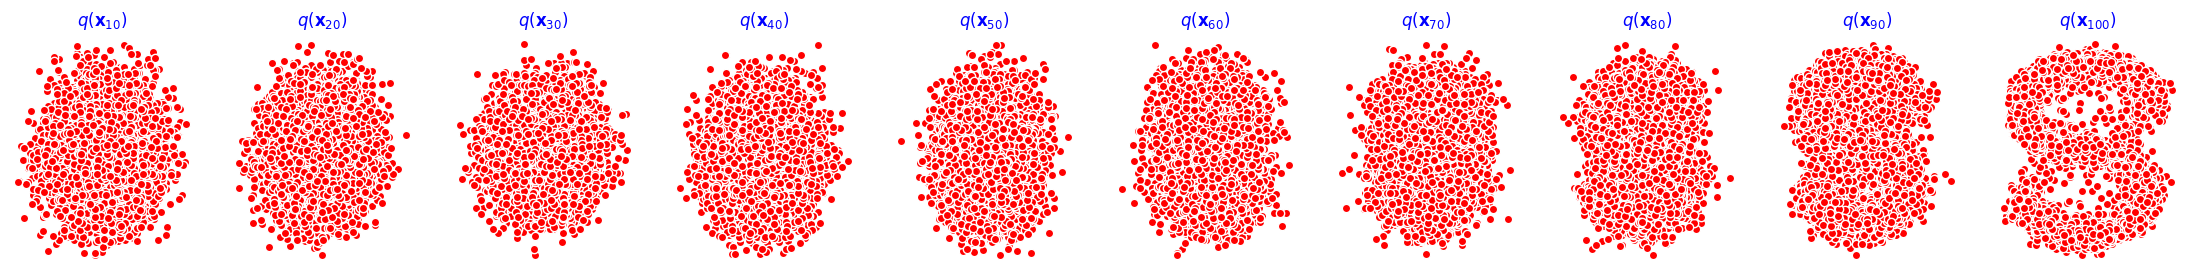

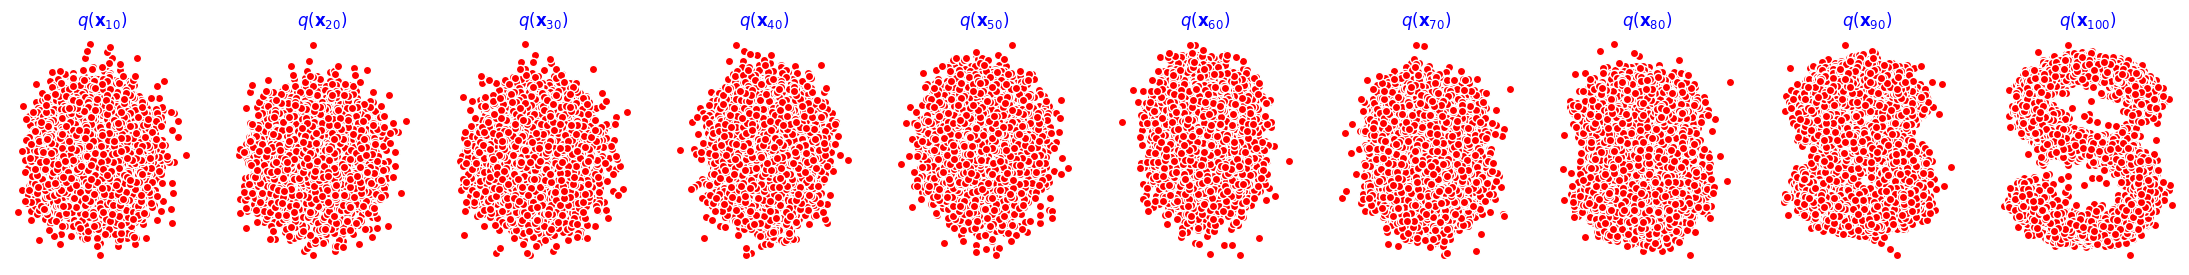

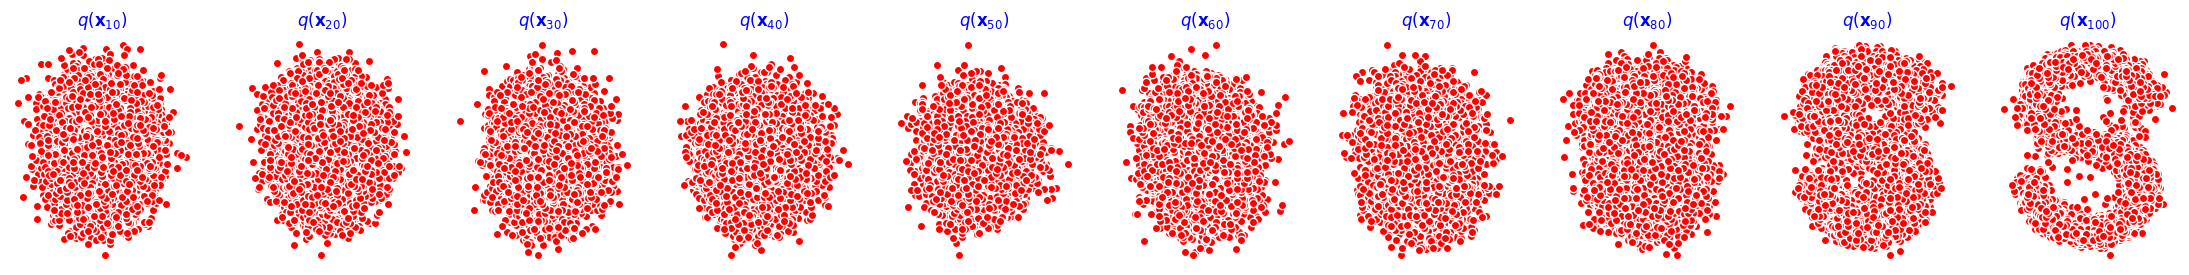

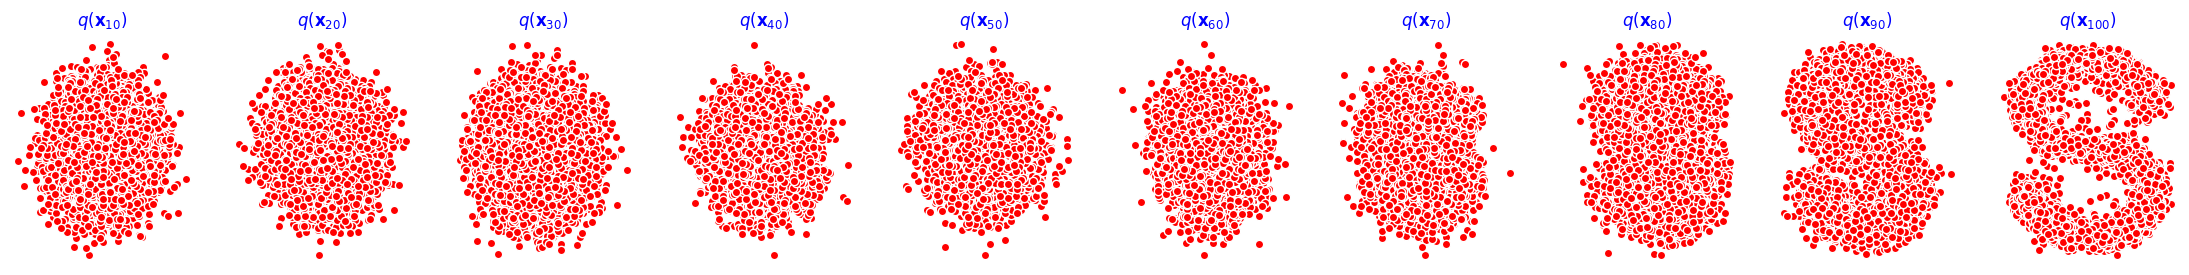

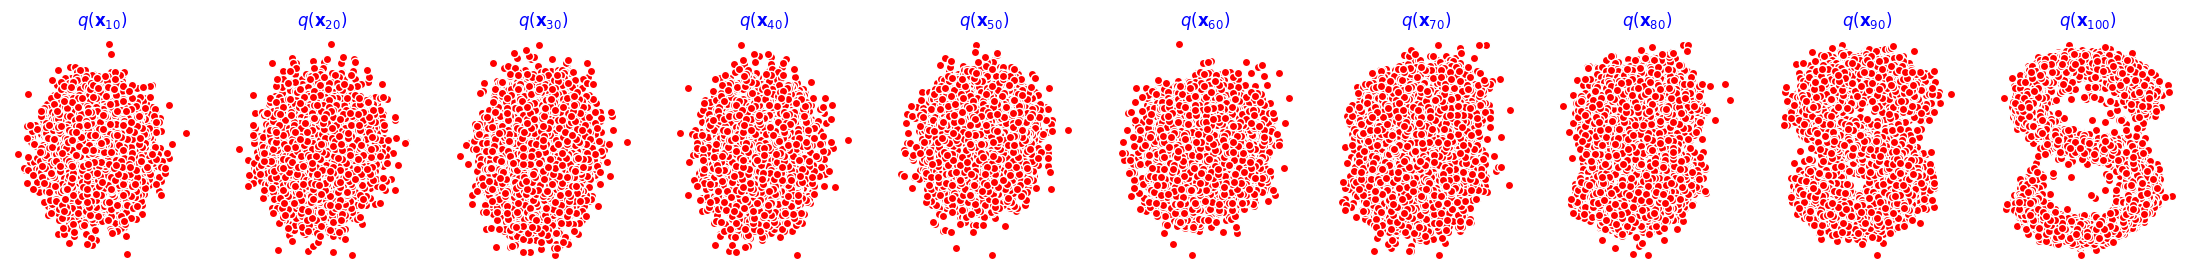

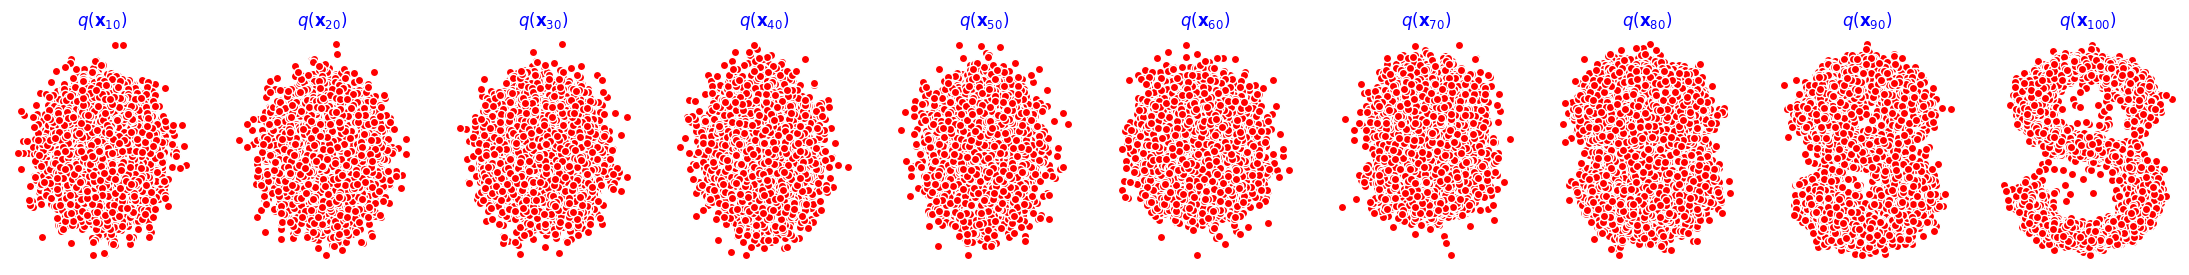

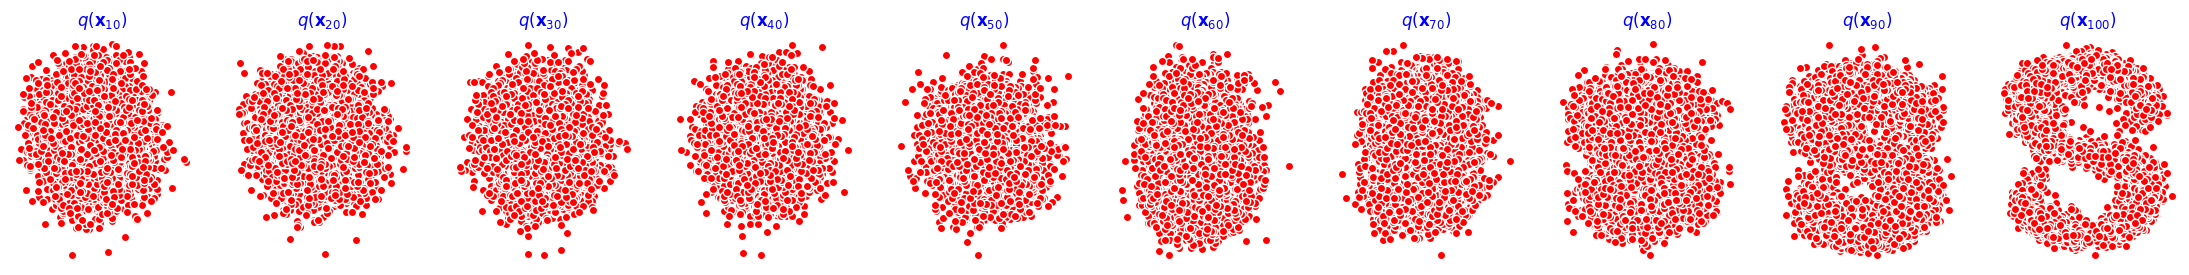

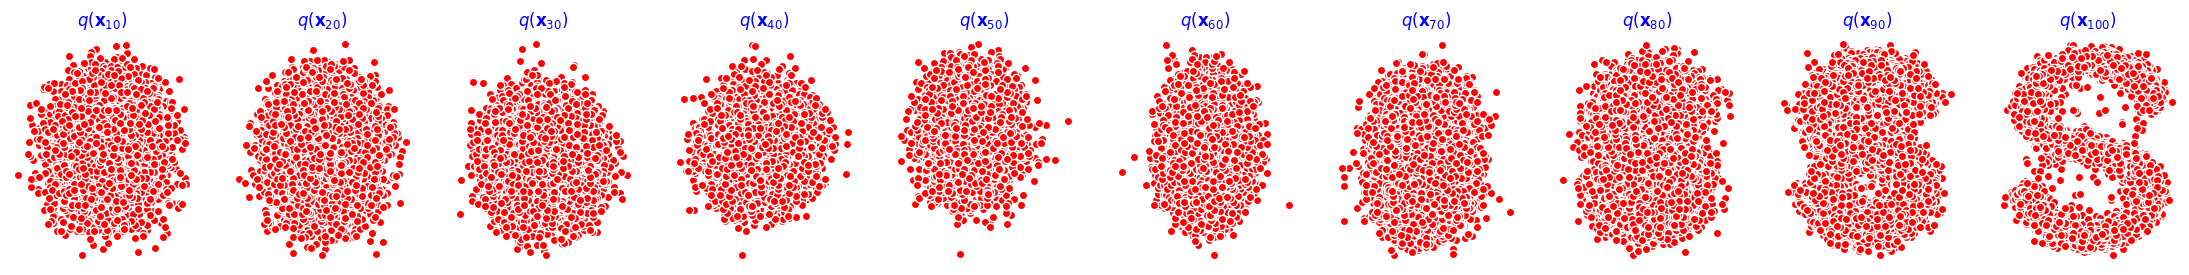

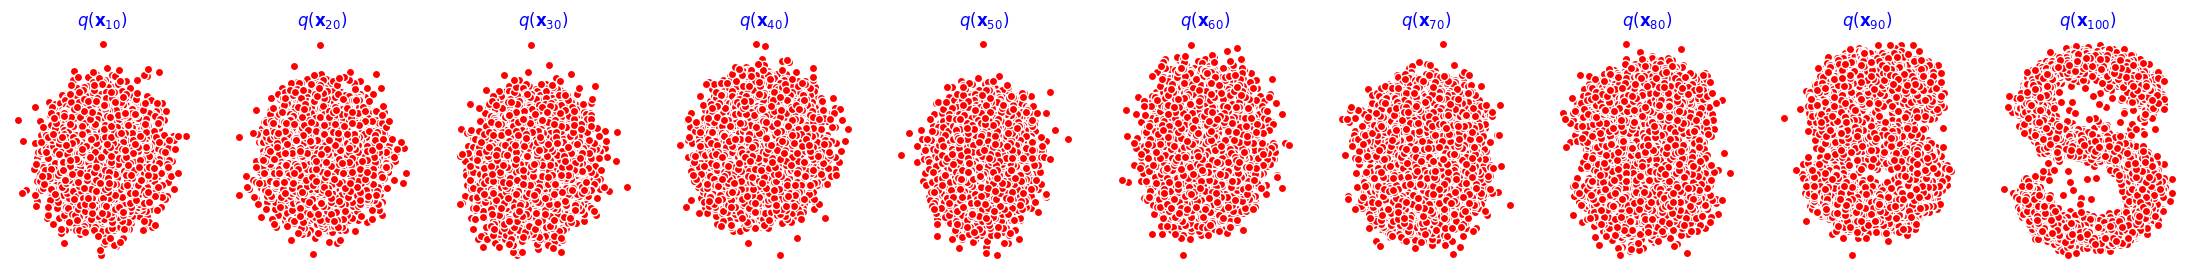

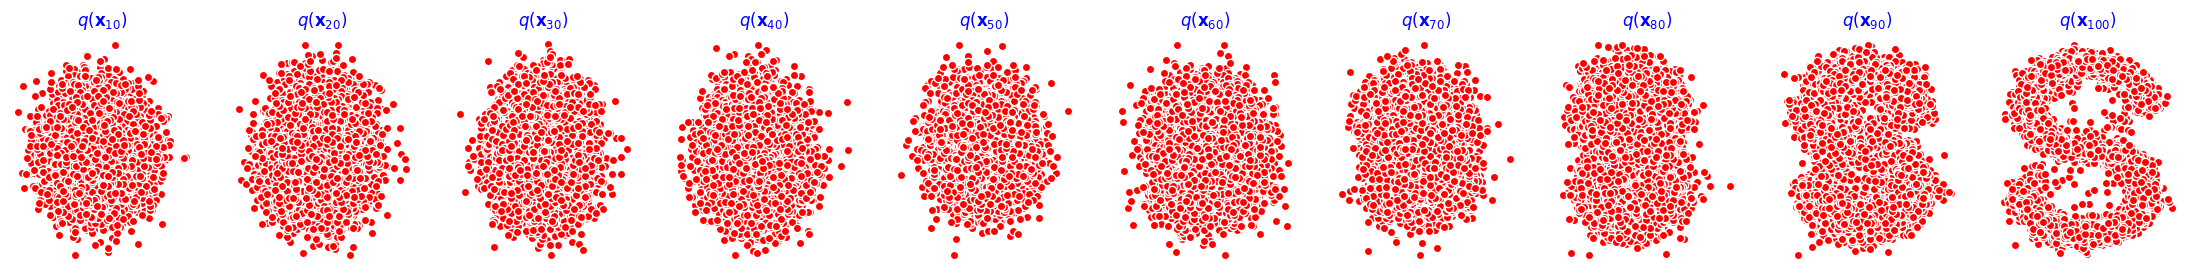

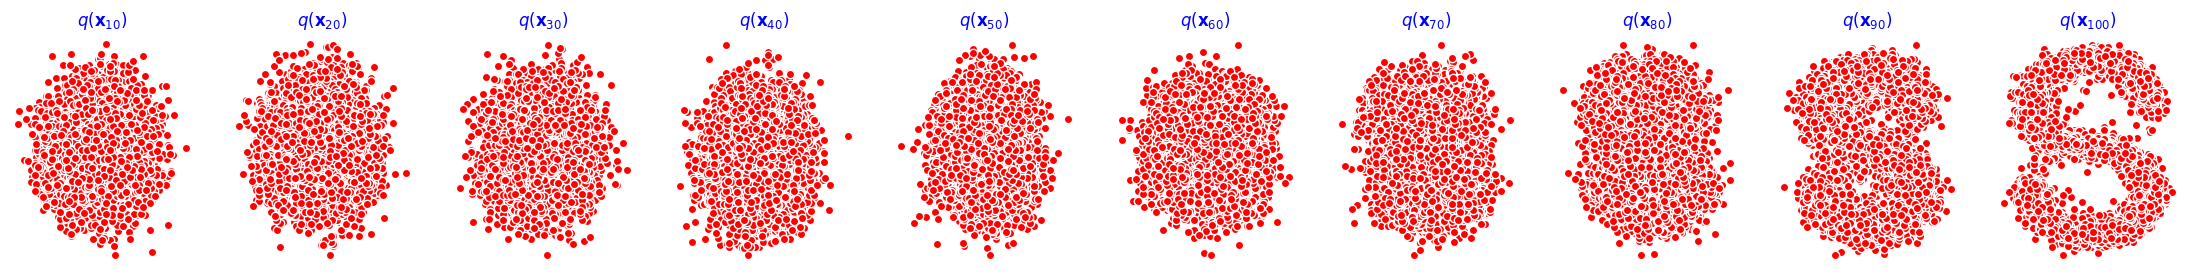

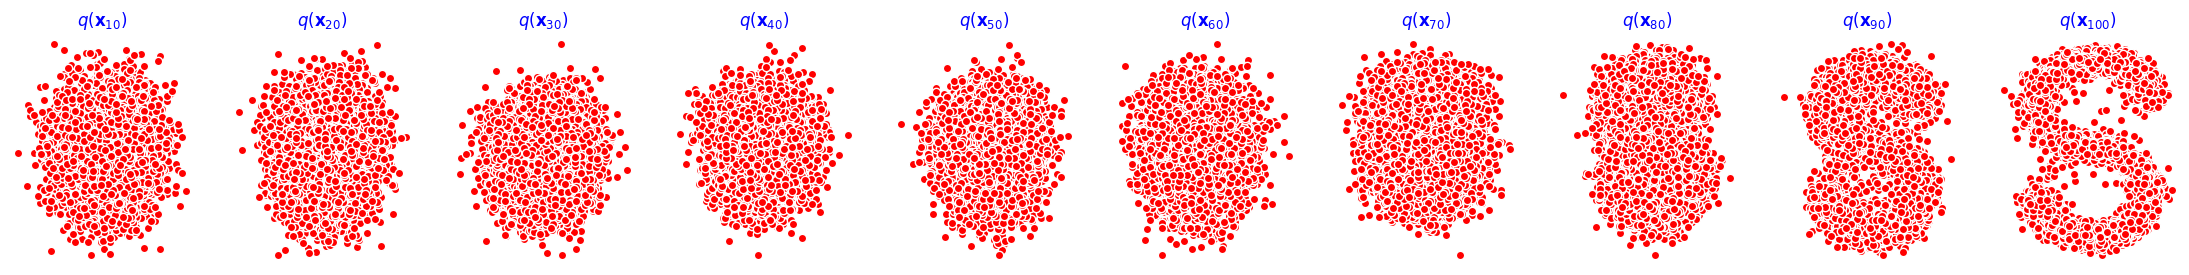

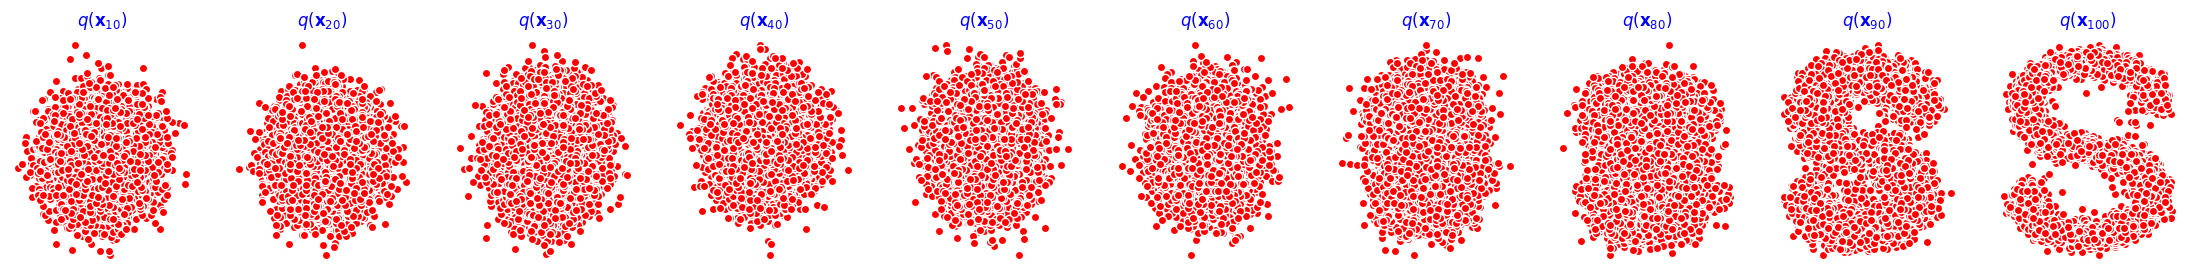

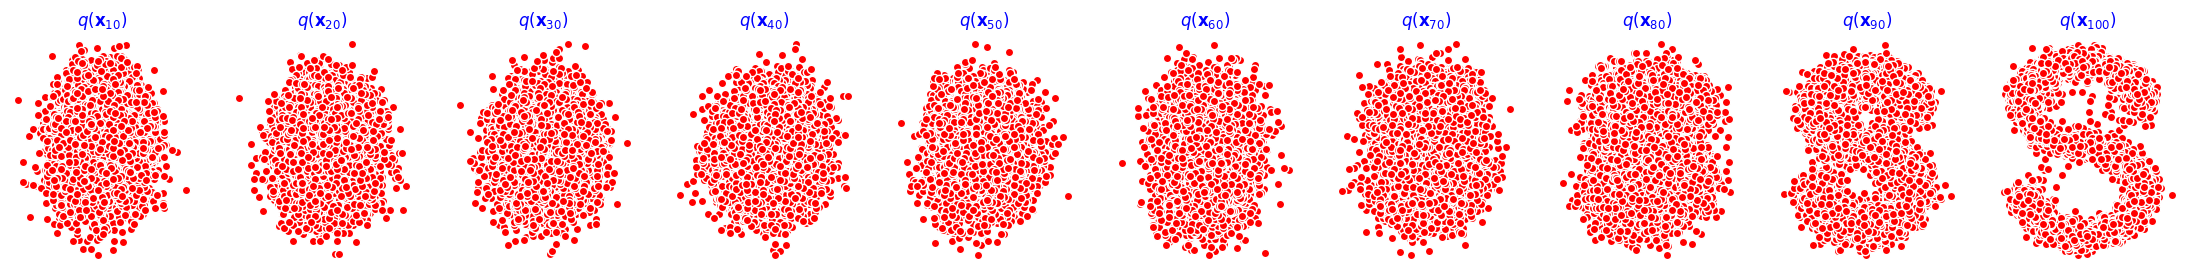

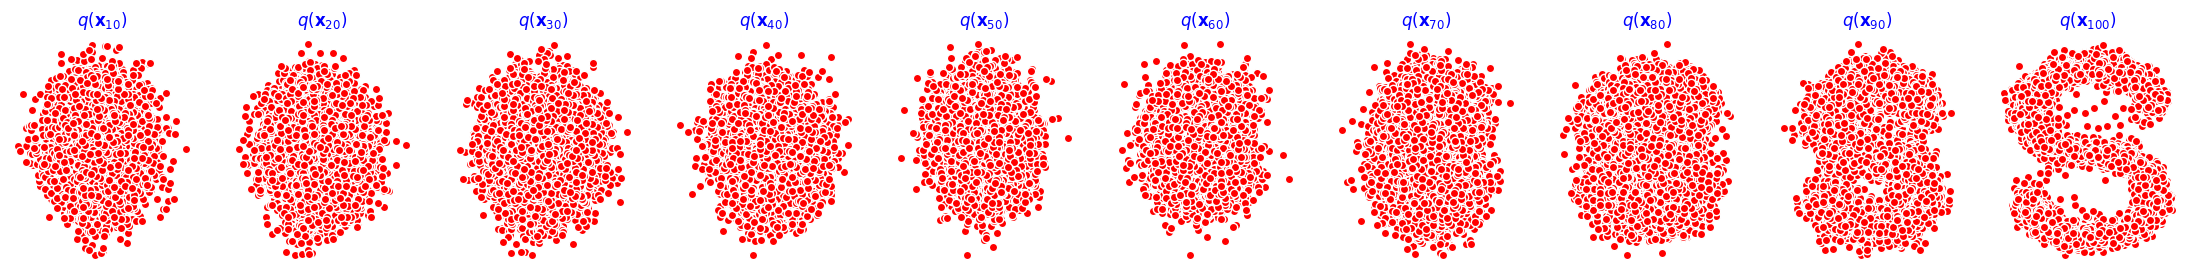

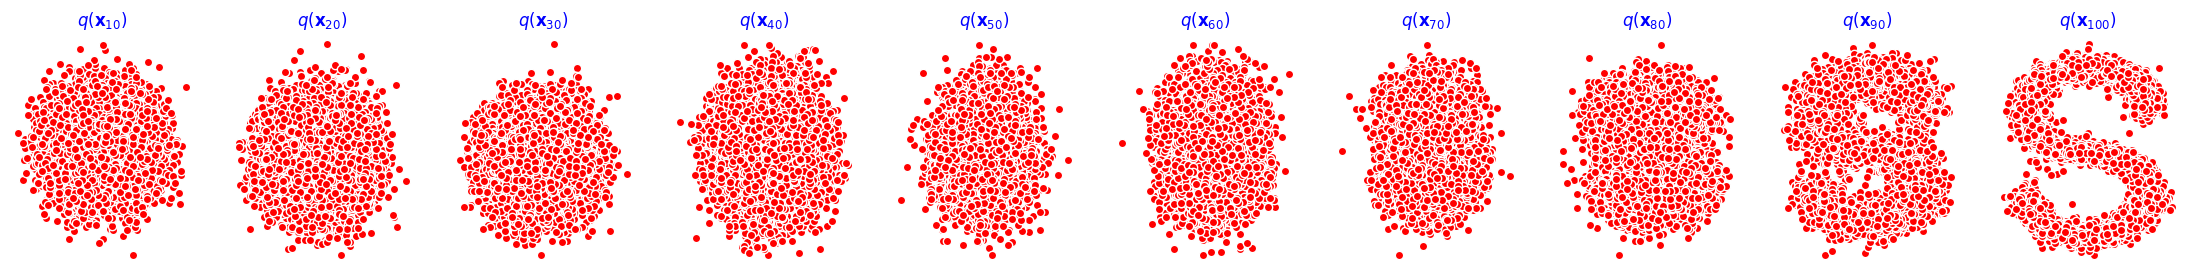

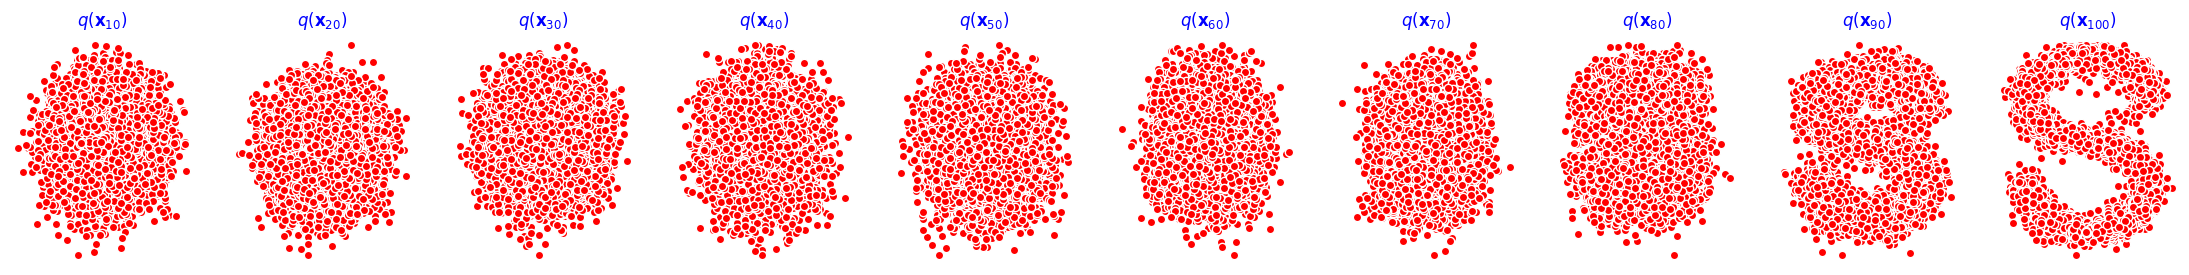

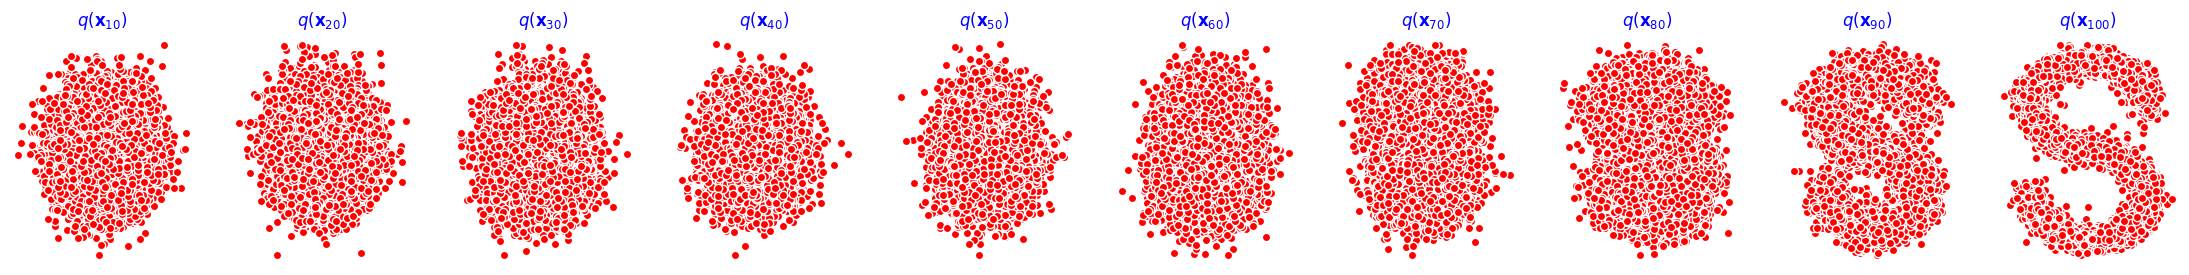

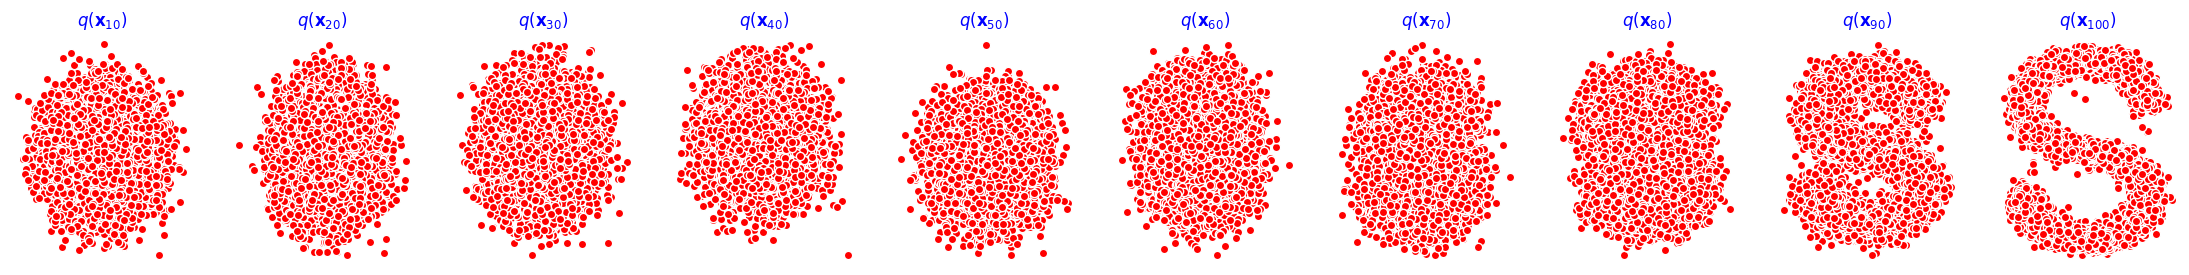

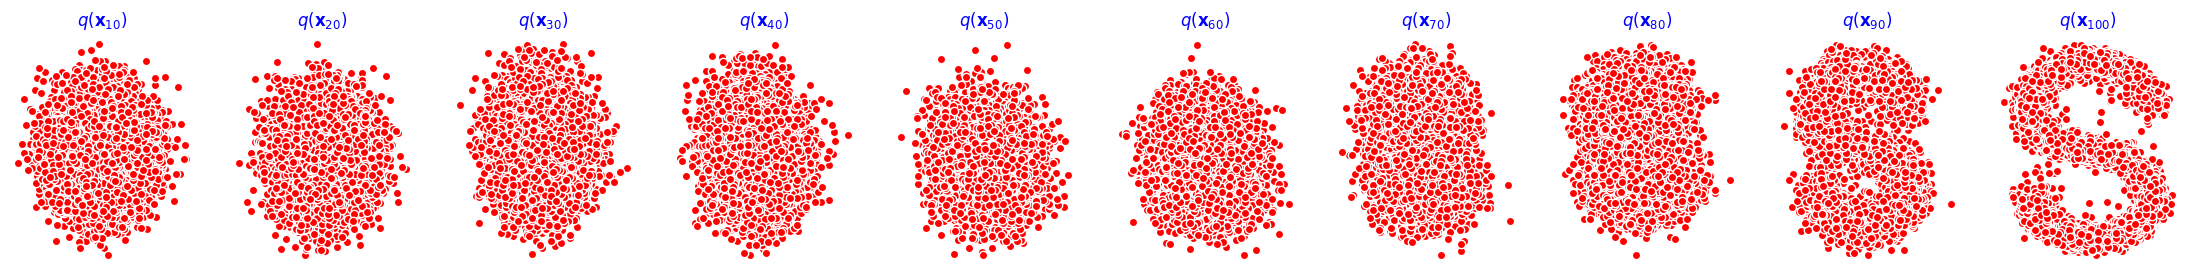

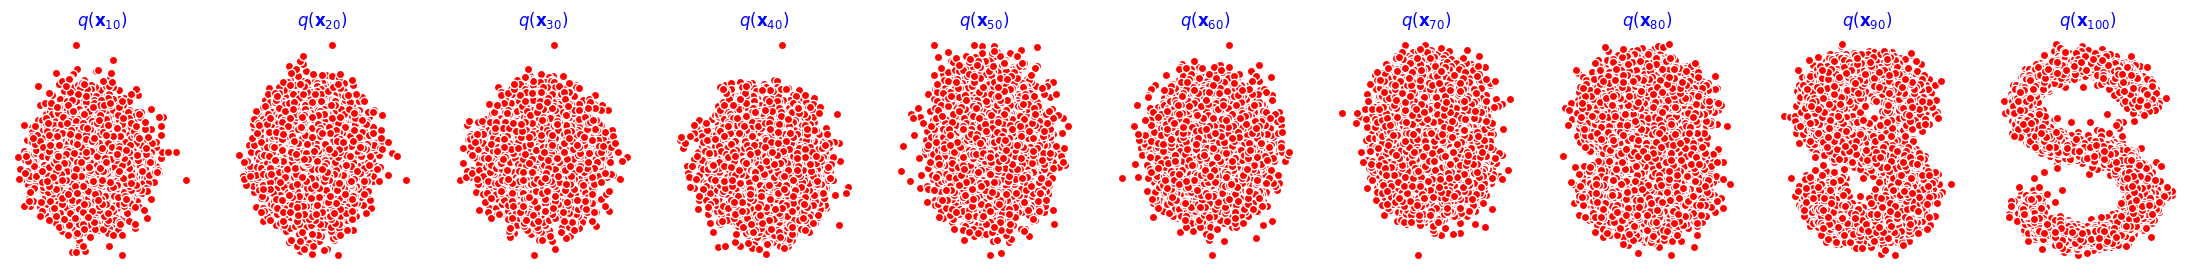

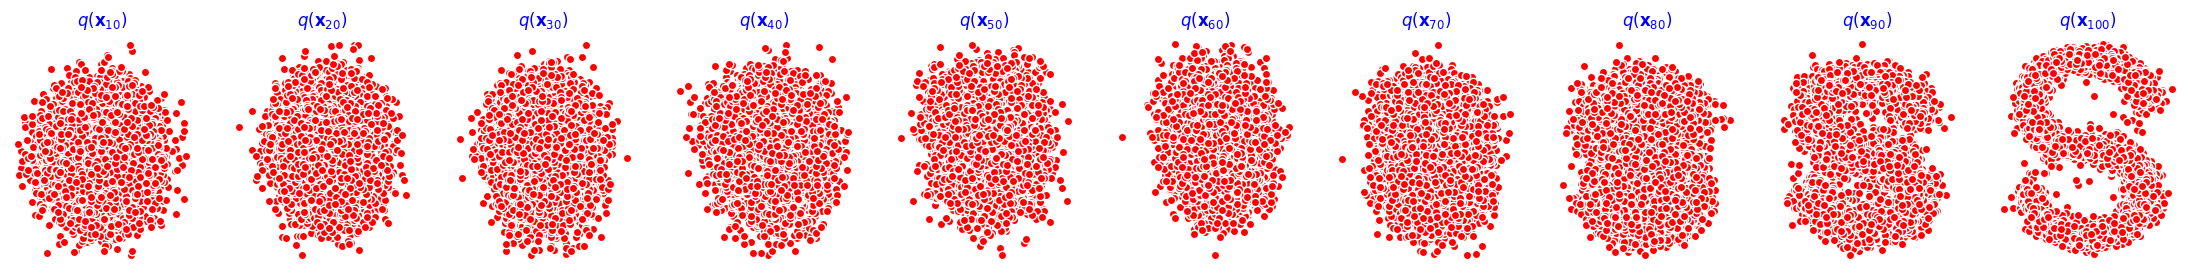

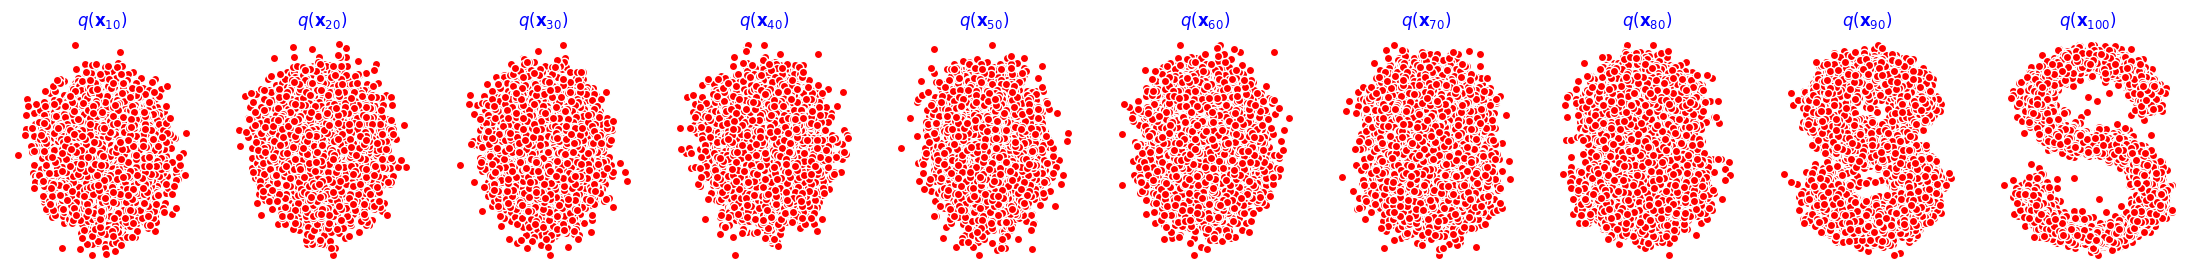

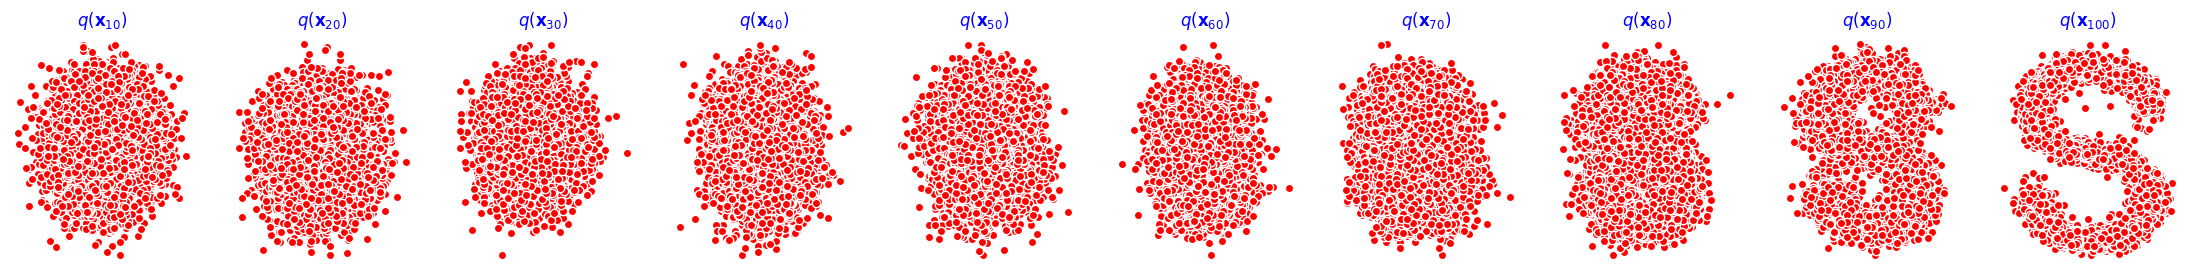

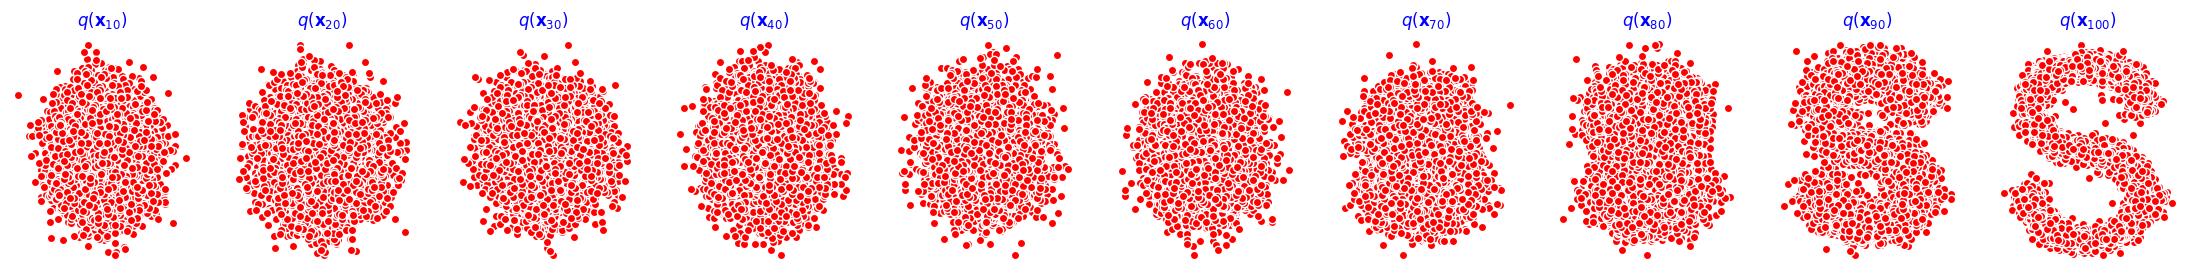

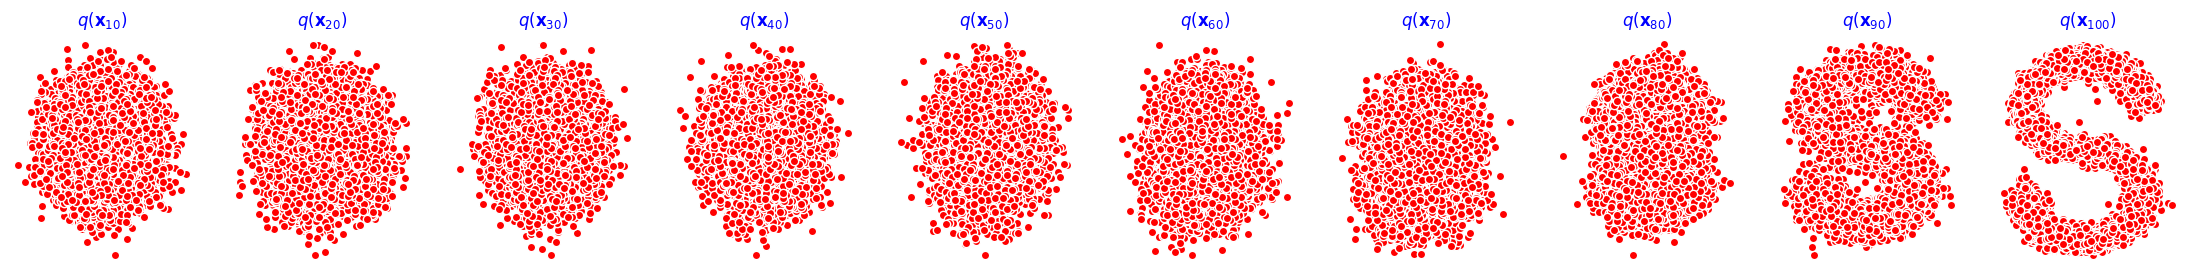

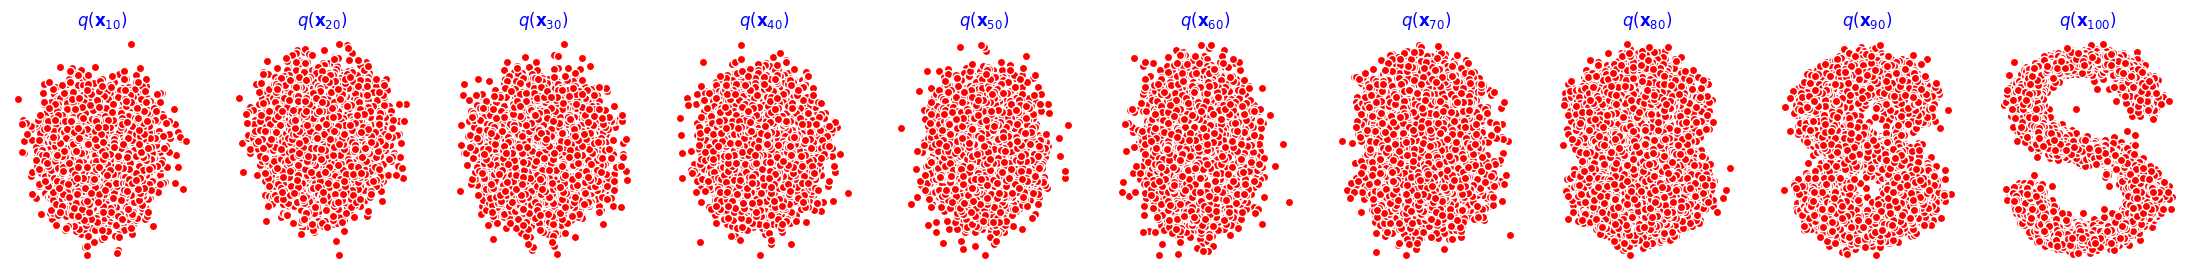

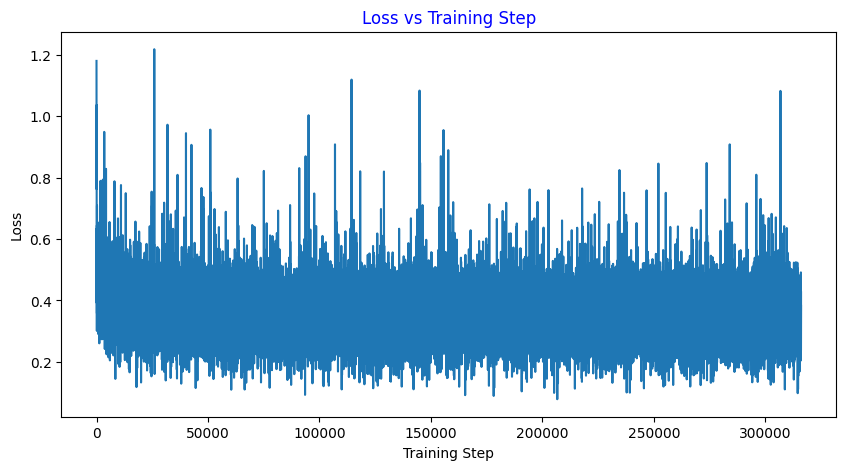

In [8]:
seed = 1234

class EMA():
    """构建一个参数平滑器"""
    def __init__(self,mu=0.01):
        self.mu = mu
        self.shadow = {}
        
    def register(self,name,val):
        self.shadow[name] = val.clone()
        
    def __call__(self,name,x):
        assert name in self.shadow
        new_average = self.mu * x + (1.0-self.mu)*self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average
    
print('Training model...')
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 4000
plt.rc('text',color='blue')

# 输出维度是2，输入是x和step
model = MLPDiffusion(num_steps)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

losses = []  # 创建一个空的列表来存储损失值

for t in range(num_epoch):
    for idx,batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model,batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.)
        optimizer.step()
        
        losses.append(loss.item())  # 将当前的损失值添加到列表中
        
    if(t%100==0):
        print(loss)
        x_seq = p_sample_loop(model,dataset.shape,num_steps,betas,one_minus_alphas_bar_sqrt)
        
        fig,axs = plt.subplots(1,10,figsize=(28,3))
        for i in range(1,11):
            cur_x = x_seq[i*10].detach()
            axs[i-1].scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white')
            axs[i-1].set_axis_off()
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

# 绘制损失函数随训练步数的折线图
plt.figure(figsize=(10,5))
plt.plot(losses)
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Loss vs Training Step')
plt.show()
